In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True) 

# Base.classes.station.__table__.columns.keys()
# Base.classes.measurement.__table__.columns.keys()

/var/folders/8c/xty3tjh57sj31d29cmxjwq5c0000gn/T/ipykernel_57237/3603796344.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent

('2017-08-23',)

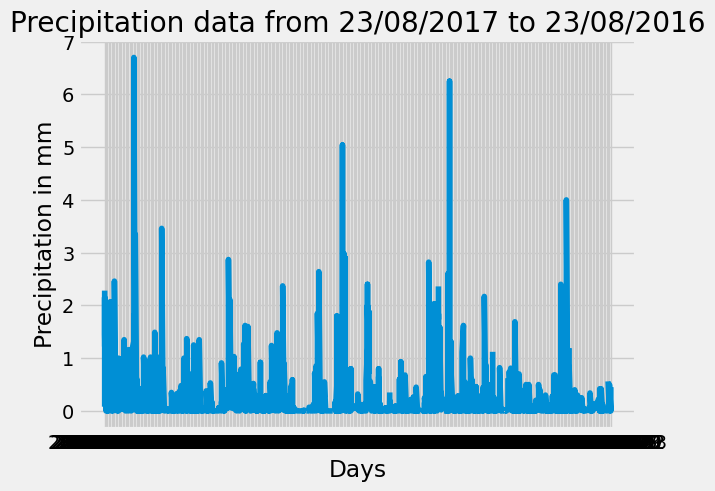

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_before = dt.date(2017,8,23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
twelve_mo_precip = session.query(measurement.date, measurement.prcp).filter(measurement.date>year_before).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
twelve_mo_precip_df = pd.DataFrame(twelve_mo_precip)

# Sort the dataframe by date
twelve_mo_precip_df = twelve_mo_precip_df.set_index('date')
twelve_mo_precip_df = twelve_mo_precip_df.sort_index()
twelve_mo_precip_df.head(20)

# Use Pandas Plotting with Matplotlib to plot the data
x_values = twelve_mo_precip_df.index.tolist()
y_values = twelve_mo_precip_df["prcp"].tolist()

plt.plot(x_values, y_values)
plt.title("Precipitation data from 23/08/2017 to 23/08/2016")
plt.xlabel("Days")
plt.ylabel("Precipitation in mm")
plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = twelve_mo_precip_df.describe()
print(summary_stats)

              prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station.station).count()
print(total_stations)

9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_station = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_station                                                                                                                  

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active_station[0][0]).all()
highest_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active_station[0][0]).all()
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active_station[0][0]).all()

lowest_temp_str = str(lowest_temp)
highest_temp_str = str(highest_temp)
avg_temp_str = str(avg_temp)

print("Lowest Temp: " + lowest_temp_str + ", Highest Temp: " + highest_temp_str + ", Average Temp:" + avg_temp_str)

Lowest Temp: [(54.0,)], Highest Temp: [(85.0,)], Average Temp:[(71.66378066378067,)]


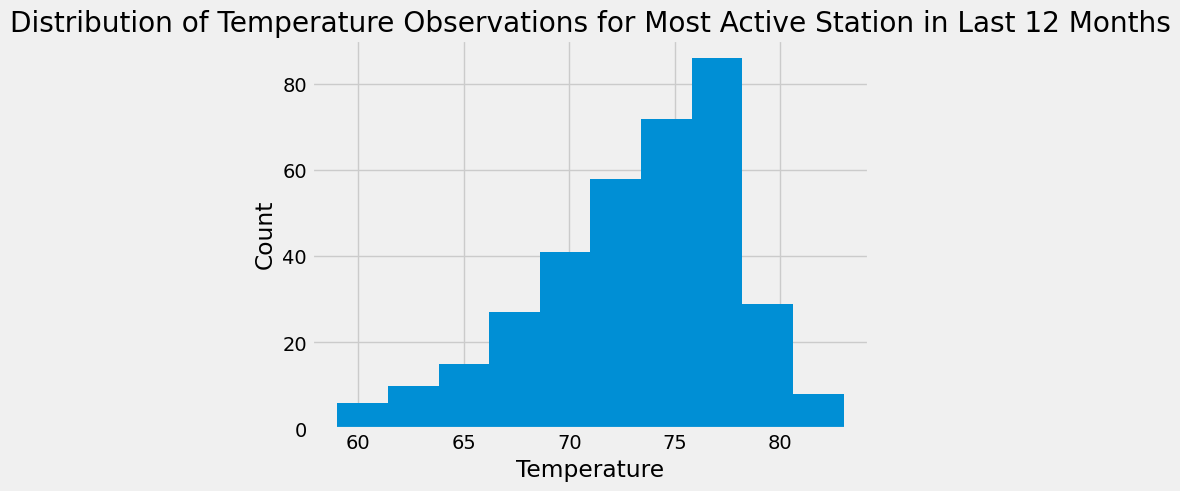

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_temp = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
most_temp_station = most_temp[0]

results = session.query(measurement.tobs).filter(measurement.date >=year_before).filter(measurement.station == most_temp_station).all()

results_pd = pd.DataFrame(results, columns = ['temperature'])

plt.hist(results_pd)
plt.title("Distribution of Temperature Observations for Most Active Station in Last 12 Months")
plt.xlabel("Temperature")
plt.ylabel("Count")
plt.show()

# Close Session

In [22]:
# Close Session
session.close()